# Simulation of batch experiment

In [2]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

import cobra
import reframed
from cobra.io import load_model
import pandas as pd
import copy
import molmass

import sys
sys.path.append("../functions/")

%load_ext autoreload
%autoreload 2

import dfba_cobra_cellulose

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Prepare for simulation

In [3]:
cellulose_exp = pd.read_csv("../input/Desvaux2001_batch_data/cellulose_g.csv")
biomass_exp = pd.read_csv("../input/Desvaux2001_batch_data/biomass_mg.csv")
ethanol = pd.read_csv("../input/Desvaux2001_batch_data/ethanol_mmol.csv")
acetate = pd.read_csv("../input/Desvaux2001_batch_data/acetate_mmol.csv")
lactate = pd.read_csv("../input/Desvaux2001_batch_data/lactate_mmol.csv")
pyruvate = pd.read_csv("../input/Desvaux2001_batch_data/pyruvate_umol.csv")
cellobiose = pd.read_csv("../input/Desvaux2001_batch_data/cellobiose_mmol.csv")
glucose = pd.read_csv("../input/Desvaux2001_batch_data/glucose_mmol.csv")


**Calculate specific production rates**

In [4]:
diff_bio = ((biomass_exp[biomass_exp.x<70].shift(-1)[" y"]-biomass_exp[biomass_exp.x<70][" y"]).mean()/1000)
diff_ac = (acetate[acetate.x<70].shift(-1)[" y"]-acetate[acetate.x<70][" y"]).mean()
diff_lac = (lactate[lactate.x<70].shift(-1)[" y"]-lactate[lactate.x<70][" y"]).mean()
diff_etoh = (ethanol[ethanol.x<70].shift(-1)[" y"]-ethanol[ethanol.x<70][" y"]).mean()
#diff_pyr = (pyruvate[pyruvate.x<70].shift(-1)[" y"]-pyruvate[pyruvate.x<70][" y"]).mean()/1000

In [5]:
model = reframed.load_cbmodel("../models/RcH10_final.xml")
model.reactions.R_EX_gal_e.ub=0
model.reactions.R_EX_rib__D_e.ub=0
model.add_ratio_constraint("R_Growth","R_EX_ac_e",round((diff_bio/diff_ac),2))
model.add_ratio_constraint("R_Growth","R_EX_etoh_e",round(diff_bio/diff_etoh,2)) 
model.add_ratio_constraint("R_Growth","R_EX_lac__L_e",round(diff_bio/diff_lac,2)) 
#model.add_ratio_constraint("R_Growth","R_EX_pyr_e",round(diff_ac/diff_pyr,2)) 
reframed.save_cbmodel(model,"../models/RcH10_final_flux_ratio.xml")
model = cobra.io.read_sbml_model('../models/RcH10_final_flux_ratio.xml')
 

medium = model.medium

medium["EX_glc__D_e"]=10.0
model.medium = medium
cobra.util.add_lp_feasibility(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-27


In [6]:
#ts = np.linspace(0, 150, 1000)  # Desired integration resolution and interval
ts = np.linspace(0, 81, 1000)  # Desired integration resolution and interval

y0 = [0.02,0,0,0,0,0,0,38.53897]

rxns = ["Growth","EX_glc__D_e","EX_cellb_e","EX_ac_e","EX_etoh_e","EX_lac__L_e","EX_pyr_e"]
objective_dir = ["max","max","max","min","min","min","min"]


with tqdm() as pbar:
    dfba_cobra_cellulose.dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dfba_cobra_cellulose.dynamic_system,
        t_span=(ts.min(), ts.max()),
        y0=y0,
        #t_eval=ts,
        method='LSODA',
        events = [dfba_cobra_cellulose.infeasible_event],
        args = (model,rxns,objective_dir,)
    )

t = 74.165: : 343it [01:06,  5.14it/s]


#### Process data and plot results

In [7]:

rxns_map = rxns.copy()
rxns_map.append("EX_cellulose_e")
C_results = dict(zip(rxns_map,sol.y))

t_extend = np.linspace(sol.t[-1],150)#[1:]
C_extend = {rxn:np.array([c[-1] for item in t_extend]) for rxn,c in C_results.items()}


## Before growth hault
names = []
C_time_series = {}
for key,values in C_results.items():
    if key!="EX_cellulose_e" and key!="Growth":
        met = model.reactions.get_by_id(key)
        met_name = list(met.metabolites.keys())[0].name
    elif key=="EX_cellulose_e":
        met_name = "Cellulose (hexose eq.)"
    elif key=="Growth":
        met_name = "Biomass"
    C_time_series[met_name]=values
    
C_df = pd.DataFrame(C_time_series)
C_df.index = sol.t
molar_mass = 173.85  # Based on glucose equivalent (based on 0.35 cellobiose and 0.3 glucose)
C_df["Cellulose (hexose eq.)"] = C_df["Cellulose (hexose eq.)"]*molar_mass/1000 # [g]


## After growth stop
C_time_series_2 = {}
for key,values in C_extend.items():
    if key!="EX_cellulose_e" and key!="Growth":
        met = model.reactions.get_by_id(key)
        met_name = list(met.metabolites.keys())[0].name
    elif key=="EX_cellulose_e":
        met_name = "Cellulose (hexose eq.)"
    elif key=="Growth":
        met_name = "Biomass"
    C_time_series_2[met_name]=values

C_df2 = pd.DataFrame(C_time_series_2)
C_df2.index = t_extend
molar_mass = 173.85  # Based on glucose equivalent (based on 0.35 cellobiose and 0.3 glucose)
C_df2["Cellulose (hexose eq.)"] = C_df2["Cellulose (hexose eq.)"]*molar_mass/1000 # [g]

In [8]:
from matplotlib.gridspec import GridSpec

#### Convert to grams

In [9]:
Mm_glc = molmass.Formula(model.metabolites.get_by_id("glc__D_c").formula).mass
Mm_cellb = molmass.Formula(model.metabolites.get_by_id("cellb_c").formula).mass
Mm_ac = molmass.Formula(model.metabolites.get_by_id("ac_c").formula).mass
Mm_lac = molmass.Formula(model.metabolites.get_by_id("lac__L_c").formula).mass
Mm_etoh = molmass.Formula(model.metabolites.get_by_id("etoh_c").formula).mass

C_df_copy = C_df.copy()
C_df_copy["D-Glucose"] = C_df_copy["D-Glucose"].map(lambda x: x*Mm_glc/1000) # mmol -> g: mmol*g/mol = g/1000 
C_df_copy["Cellobiose"] = C_df_copy["Cellobiose"].map(lambda x: x*Mm_cellb/1000) # mmol -> g: mmol*g/mol = g/1000 
C_df_copy["Acetate"] = C_df_copy["Acetate"].map(lambda x: x*Mm_ac/1000) # mmol -> g: mmol*g/mol = g/1000 
C_df_copy["L-Lactate"] = C_df_copy["L-Lactate"].map(lambda x: x*Mm_lac/1000) # mmol -> g: mmol*g/mol = g/1000 
C_df_copy["Ethanol"] = C_df_copy["Ethanol"].map(lambda x: x*Mm_etoh/1000) # mmol -> g: mmol*g/mol = g/1000 


C_df2_copy = C_df2.copy()
C_df2_copy["D-Glucose"] = C_df2_copy["D-Glucose"].map(lambda x: x*Mm_glc/1000) # mmol -> g: mmol*g/mol = g/1000 
C_df2_copy["Cellobiose"] = C_df2_copy["Cellobiose"].map(lambda x: x*Mm_cellb/1000) # mmol -> g: mmol*g/mol = g/1000 
C_df2_copy["Acetate"] = C_df2_copy["Acetate"].map(lambda x: x*Mm_ac/1000) # mmol -> g: mmol*g/mol = g/1000 
C_df2_copy["L-Lactate"] = C_df2_copy["L-Lactate"].map(lambda x: x*Mm_lac/1000) # mmol -> g: mmol*g/mol = g/1000 
C_df2_copy["Ethanol"] = C_df2_copy["Ethanol"].map(lambda x: x*Mm_etoh/1000) # mmol -> g: mmol*g/mol = g/1000 

cellobiose_copy = cellobiose.copy()
cellobiose_copy[" y"] = cellobiose_copy[" y"].map(lambda x: x*Mm_cellb/1000) # mmol -> g: mmol*g/mol = g/1000 
glucose_copy = glucose.copy()
glucose_copy[" y"] = glucose_copy[" y"].map(lambda x: x*Mm_glc/1000) # mmol -> g: mmol*g/mol = g/1000 


acetate_copy = acetate.copy()
acetate_copy[" y"] = acetate_copy[" y"].map(lambda x: x*Mm_ac/1000) # mmol -> g: mmol*g/mol = g/1000 
lactate_copy = lactate.copy()
lactate_copy[" y"] = lactate_copy[" y"].map(lambda x: x*Mm_lac/1000) # mmol -> g: mmol*g/mol = g/1000 
ethanol_copy = ethanol.copy()
ethanol_copy[" y"] = ethanol_copy[" y"].map(lambda x: x*Mm_etoh/1000) # mmol -> g: mmol*g/mol = g/1000 

### Plot figures

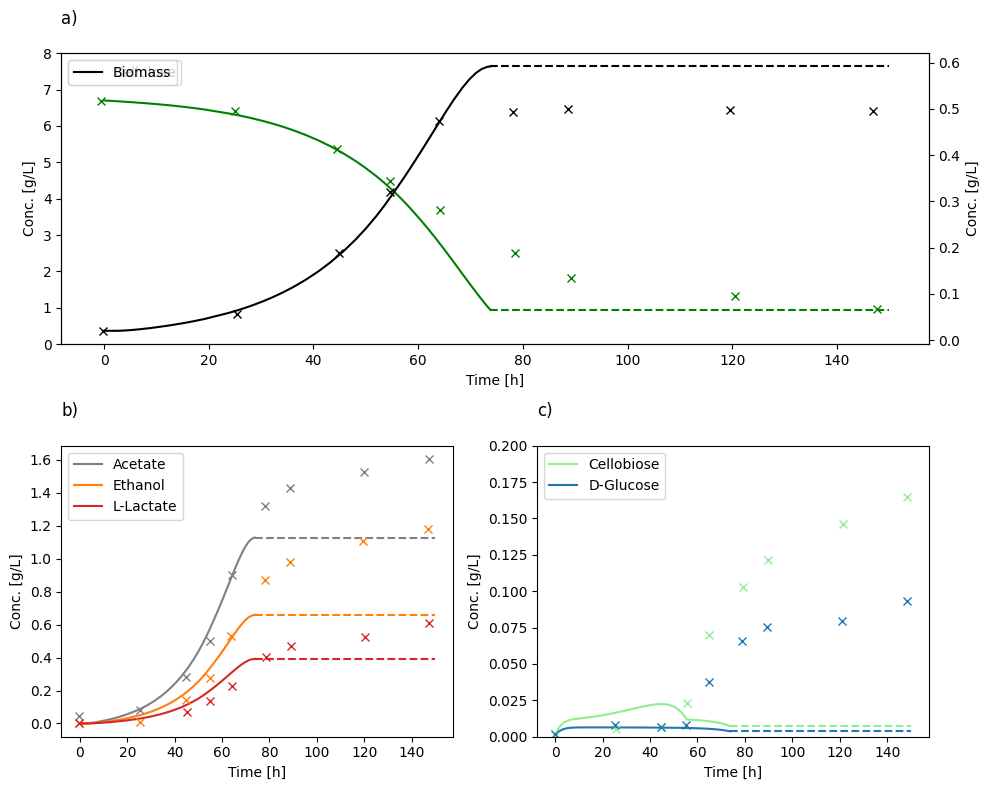

In [10]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(4,6,figure=fig)
ax1 = fig.add_subplot(gs[0:2, :])
#ax3 = fig.add_subplot(gs[2:3,1:5])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[2:,0:3])
ax3 = fig.add_subplot(gs[2:,3:])


C_df.loc[:,["Cellulose (hexose eq.)"]].plot(ax=ax1,xlabel="Time [h]",ylabel="Conc. [g/L]",color="green")
C_df2.loc[:,["Cellulose (hexose eq.)"]].plot(ax=ax1,xlabel="Time [h]",ylabel="Conc. [g/L]",color="green",linestyle="--")

ax1.plot(cellulose_exp["x"].values,cellulose_exp[" y"].values,'x',color="green")
ax1.set_ylim([0,8])
ax1.legend(["Cellulose"],loc="upper left")
ax1_twin = ax1.twinx()

pd.Series(index=C_df.index,data=np.array(C_df["Biomass"])).plot(ax=ax1_twin,xlabel="Time [h]",ylabel="Conc. [g/L]",color="black") #1000
pd.Series(index=C_df2.index,data=np.array(C_df2["Biomass"])).plot(ax=ax1_twin,xlabel="Time [h]",ylabel="Conc. [g/L]",color="black",linestyle="--") #1000

biomass_exp_copy = biomass_exp.copy()
biomass_exp_copy[" y"] = biomass_exp_copy[" y"]/1000

ax1_twin.plot(biomass_exp_copy["x"].values,biomass_exp_copy[" y"].values,'x',color="black",)
#ax1_twin.set_ylim([0,0.8])
ax1_twin.legend(["Biomass"])


C_df_copy.loc[:,["Acetate","Ethanol","L-Lactate"]].plot(ax=ax2,color=["grey","tab:orange","tab:red"],xlabel="Time [h]",ylabel="Conc. [g/L]")
C_df2_copy.loc[:,["Acetate","Ethanol","L-Lactate"]].plot(ax=ax2,color=["grey","tab:orange","tab:red"],xlabel="Time [h]",ylabel="Conc. [g/L]",linestyle="--",legend=False)

ax2.plot(acetate_copy["x"].values,acetate_copy[" y"].values,'x',color="grey")
ax2.plot(ethanol_copy["x"].values,ethanol_copy[" y"].values,'x',color="tab:orange")
ax2.plot(lactate_copy["x"].values,lactate_copy[" y"].values,'x',color="tab:red")


C_df_copy.loc[:,["Cellobiose","D-Glucose"]].plot(ax=ax3,ylim=[0,0.2],color=["lightgreen","tab:blue"],xlabel="Time [h]",ylabel="Conc. [g/L]")
C_df2_copy.loc[:,["Cellobiose","D-Glucose"]].plot(ax=ax3,ylim=[0,0.2],color=["lightgreen","tab:blue"],xlabel="Time [h]",ylabel="Conc. [g/L]",linestyle="--",legend=False)

ax3.plot(cellobiose["x"].values,cellobiose[" y"].values,'x',color="lightgreen")
ax3.plot(glucose["x"].values,glucose[" y"].values,'x',color="tab:blue")


ax1.set_title("a)\n",loc="left")
ax2.set_title("b)\n",loc="left")
ax3.set_title("c)\n",loc="left")

plt.tight_layout()
plt.savefig("../figures/batch_replication.png")

### Comparison of ATP yield on glucose

#### Load models

In [11]:
model = reframed.load_cbmodel("../models/RcH10_v2.xml") # Before NGAM and GAM

model_iFS431 = reframed.load_cbmodel("../models/other_models/iFS431.xml",load_gprs=False,flavor="cobra")
model_iFS431.reactions.R_ATPM_LPAREN_prev_PERIOD_NGAM_RPAREN_.lb=0
model_iFS431.reactions.R_ATPM_LPAREN_prev_PERIOD_NGAM_RPAREN_.ub=1000

#### Create minimal glucose environment

In [12]:
env = reframed.Environment.from_reactions(["R_EX_h_e","R_EX_h2o_e","R_EX_glc__D_e","R_EX_atp_c","R_EX_gtp_c","R_EX_ppi_c","R_EX_nad_c"])
env["R_EX_h2o_e"]=(-1000,1000)
env["R_EX_h_e"]=(-1000,1000)


rxns_from_env = ["R_EX_"+x.split("_")[2] for x in env.keys()]
exchange_rxns = model_iFS431.get_exchange_reactions()
exchange_rxns_dict = {"_".join(x.split("_")[0:3]):x for x in exchange_rxns}
env_old_model = reframed.Environment.from_reactions([old_id for new_id, old_id in exchange_rxns_dict.items() if new_id in rxns_from_env])
env_old_model["R_EX_h2o_LPAREN_e_RPAREN_"]=(-100,100)
env_old_model["R_EX_h_LPAREN_e_RPAREN_"]=(-100,100)


rxns_new = ["R_EX_ac_e","R_EX_etoh_e","R_EX_lac__L_e","R_ATPM"]
rxns_inf = ["R_EX_ac_LPAREN_e_RPAREN_","R_EX_etoh_LPAREN_e_RPAREN_","R_EX_lac_DASH_D_LPAREN_e_RPAREN_","R_ATPM_LPAREN_prev_PERIOD_NGAM_RPAREN_"]

rxns_dict = dict(zip(rxns_inf,rxns_new))

#### Apply environment

In [13]:
env.apply(model,inplace=True,warning=False)
env_old_model.apply(model_iFS431,inplace=True,warning=False)

### Maximizing production of different compounds

In [14]:
fba_results = {}

for model_id,model_spec in {"model":model,"model_iFS431":model_iFS431}.items():
    
    if model_id=="model_iFS431":
        rxns = rxns_inf
    else:
        rxns = rxns_new
        
    fba_results[model_id]={}
    fba_results[model_id] = {}
    

    for rxn in rxns:
        objective = {rxn:0 for rxn in model_spec.reactions.keys()}
        objective[rxn]=1
        model_spec.set_objective(objective)
        if model_id=="model_iFS431":
            fba_results[model_id][rxns_dict[rxn]] = reframed.FBA(model_spec).fobj
        else:
            
            fba_results[model_id][rxn]= reframed.FBA(model_spec,objective={rxn:1}).fobj
            
            
        

In [15]:
pd.DataFrame(fba_results)

,model,model_iFS431
R_EX_ac_e,20.0,20.0
R_EX_etoh_e,20.0,20.0
R_EX_lac__L_e,20.0,20.0
R_ATPM,30.0,40.0
